In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

In [3]:
base_dir = "flowers/"
tulip_dir = os.path.join(base_dir, "tulip")
rose_dir = os.path.join(base_dir, "rose")
dandelion_dir = os.path.join(base_dir, "dandelion")
daisy_dir = os.path.join(base_dir, "daisy")
sunflower_dir = os.path.join(base_dir, "sunflower")

In [5]:
print("Tulip", len(os.listdir(tulip_dir)))
print("Rose", len(os.listdir(rose_dir)))
print("Dandelion", len(os.listdir(dandelion_dir)))
print("Daisy", len(os.listdir(daisy_dir)))
print("Sunflower", len(os.listdir(sunflower_dir)))

Tulip 985
Rose 784
Dandelion 1052
Daisy 764
Sunflower 733


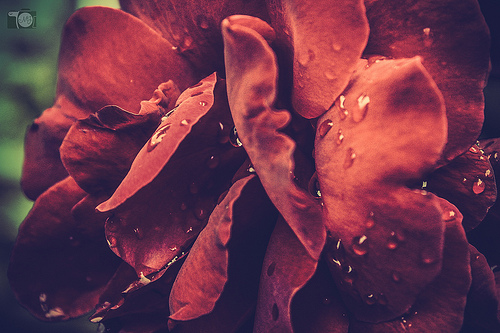

In [7]:
import random
random_image = random.sample(os.listdir(rose_dir), 1)
img = tf.keras.utils.load_img(f"{rose_dir}/{random_image[0]}")
img

In [9]:
img = tf.keras.utils.img_to_array(img)
img.shape

(333, 500, 3)

In [11]:
# Veri ön işleme
train_ds = tf.keras.utils.image_dataset_from_directory(
base_dir,
validation_split = 0.2,
subset="training",
image_size=(180,180),
batch_size = 32,
seed=42)

Found 4318 files belonging to 5 classes.
Using 3455 files for training.


In [13]:
# Resimlerin ve çıktıların boyutları
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [15]:
#train_ds'deki classları görmek
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

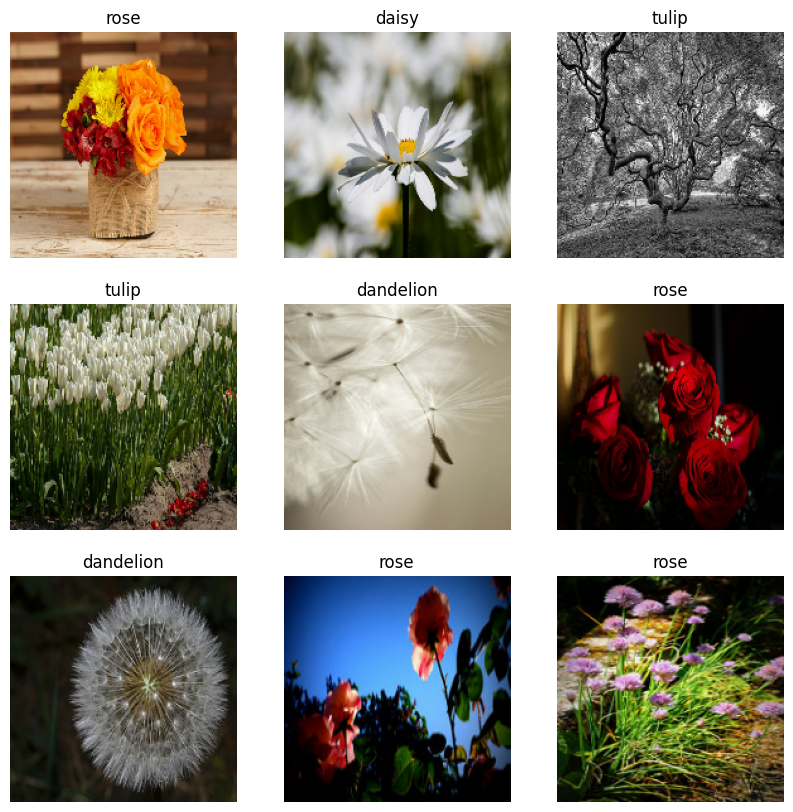

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1): # 1 grup almak için take(1) yazdık
    for i in range(9):
        ax= plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
base_dir,
validation_split = 0.2,
subset="validation",
image_size=(180,180),
batch_size = 32,
seed=42)

Found 4318 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
#Normalde veriler sırası ile okunur öyle eğitilir.
#Prefetched metodu ile bir aşamada eğitilirken diğer aşamada okunur.

In [21]:
#ImageDataGenerator model eğitim aşamasının bir parçası olmadığı için GPU desteği alamaz
#Gpu yu kullanabilmek için Keras layers'da data augmentation yapacağız
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",  seed=42),
    tf.keras.layers.RandomRotation(0.1, seed=42)
])

AxesImage(shape=(180, 180, 3))


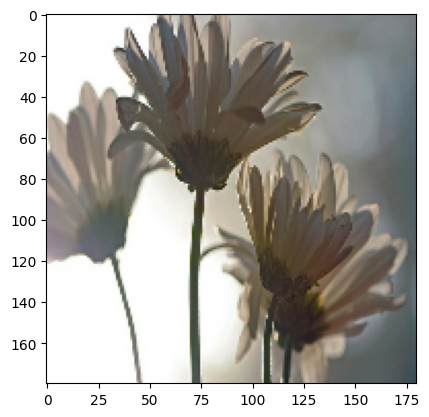

In [23]:
#Resimlerin nasıl dönüştüğünü (data augmentationda) görmek için
for images, _ in train_ds.take(1):
    print(plt.imshow(images[0].numpy().astype("uint8")))

AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))
AxesImage(shape=(180, 180, 3))


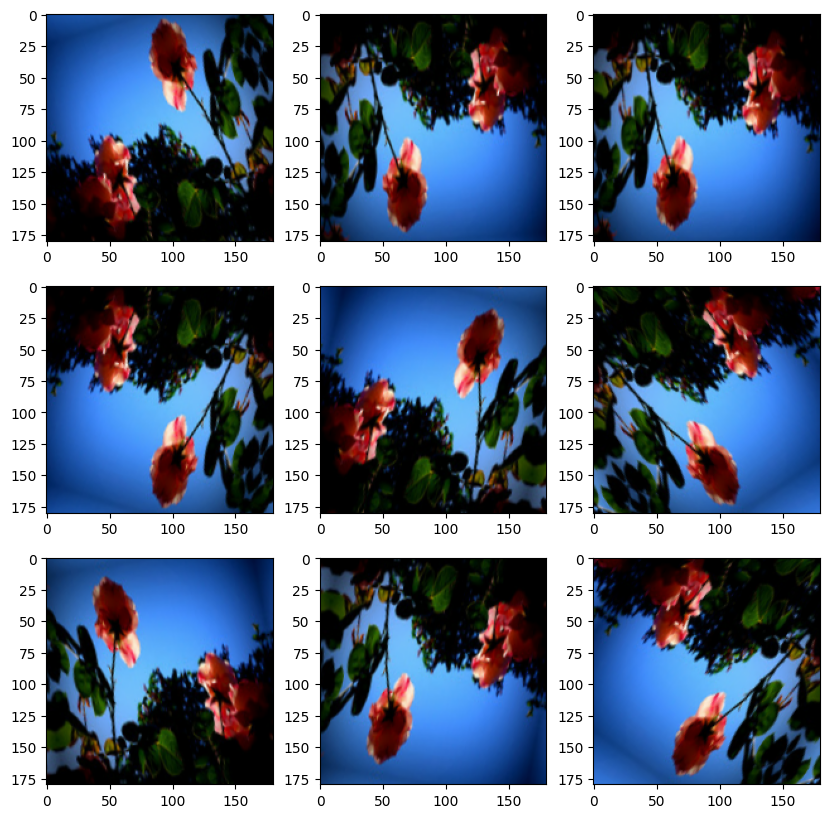

In [25]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        print(plt.imshow(augmented_images[0].numpy().astype("uint8")))

In [35]:
#model mimarisi oluşturma
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
    data_augmentation, #GPU'dan faydalanmak için
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(5)
    
])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

In [39]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"])

In [41]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 15)

Epoch 1/15
108/108 [==============================] - 214s 2s/step - loss: 1.3346 - accuracy: 0.4136 - val_loss: 1.1431 - val_accuracy: 0.4832
Epoch 2/15
108/108 [==============================] - 206s 2s/step - loss: 1.1232 - accuracy: 0.5302 - val_loss: 1.0576 - val_accuracy: 0.5678
Epoch 3/15
108/108 [==============================] - 219s 2s/step - loss: 0.9986 - accuracy: 0.6043 - val_loss: 0.9045 - val_accuracy: 0.6188
Epoch 4/15
108/108 [==============================] - 224s 2s/step - loss: 0.9266 - accuracy: 0.6376 - val_loss: 0.9601 - val_accuracy: 0.6025
Epoch 5/15
108/108 [==============================] - 209s 2s/step - loss: 0.8888 - accuracy: 0.6535 - val_loss: 0.8839 - val_accuracy: 0.6489
Epoch 6/15
108/108 [==============================] - 239s 2s/step - loss: 0.8508 - accuracy: 0.6700 - val_loss: 0.8631 - val_accuracy: 0.6408
Epoch 7/15
108/108 [==============================] - 242s 2s/step - loss: 0.8119 - accuracy: 0.6915 - val_loss: 0.8058 - val_accuracy: 0.6871

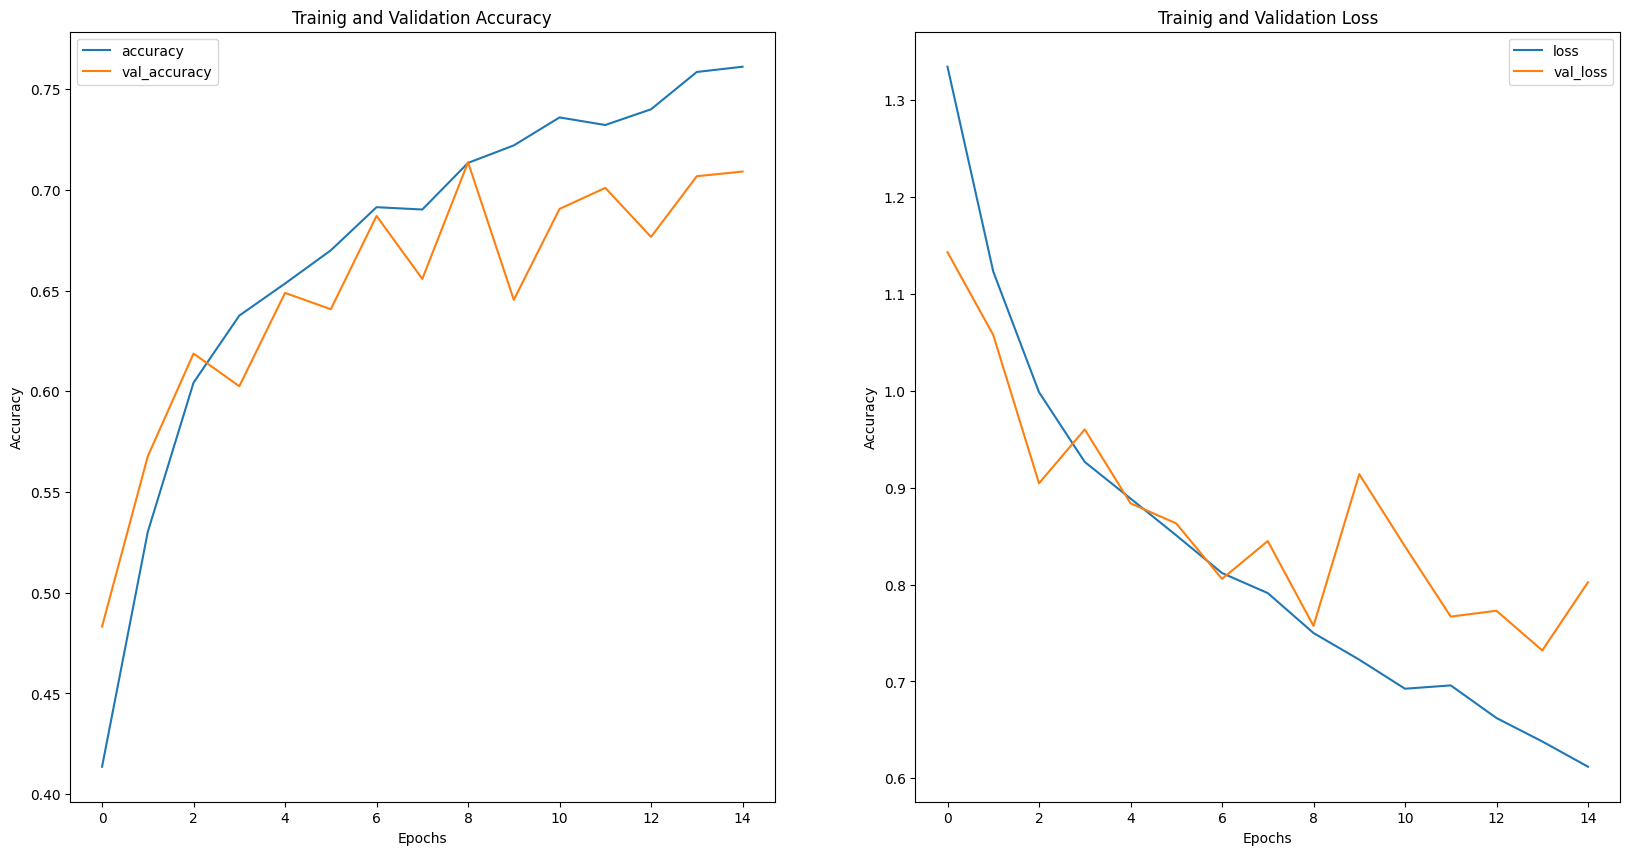

In [51]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Trainig and Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['accuracy', 'val_accuracy'])

plt.subplot(1,2,2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Trainig and Validation Loss")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['loss', 'val_loss'])

plt.show()

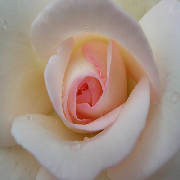

In [59]:
random_image = random.sample(os.listdir(rose_dir), 1)
img = tf.keras.utils.load_img(f"{rose_dir}/{random_image[0]}", target_size=(180,180))
img

In [61]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
img_array.shape

TensorShape([1, 180, 180, 3])

In [63]:
predictions = model.predict(img_array)

1/1 [==============================] - 0s 178ms/step


In [65]:
score = tf.nn.softmax(predictions[0])
class_names[np.argmax(score)]

'rose'